In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# import data and feature csv
data_info = pd.read_csv('lending_club_info.csv',index_col='LoanStatNew')
def feat_info(col_name): # feature information function
  print(data_info.loc[col_name]['Description'])

df = pd.read_csv('lending_club_loan_two.csv')

df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650"


<AxesSubplot: xlabel='loan_status', ylabel='count'>

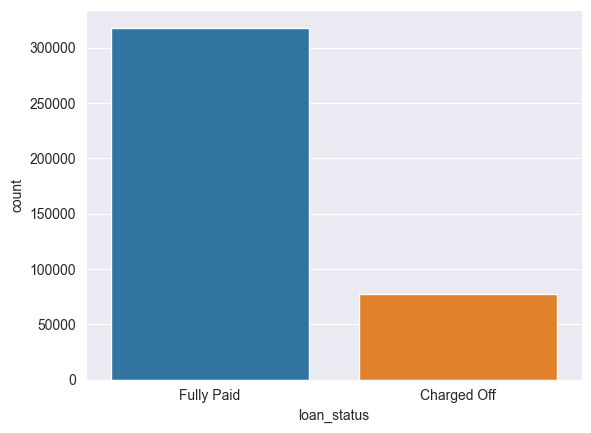

In [5]:
sns.countplot(x='loan_status',data=df)

<Figure size 1200x400 with 0 Axes>

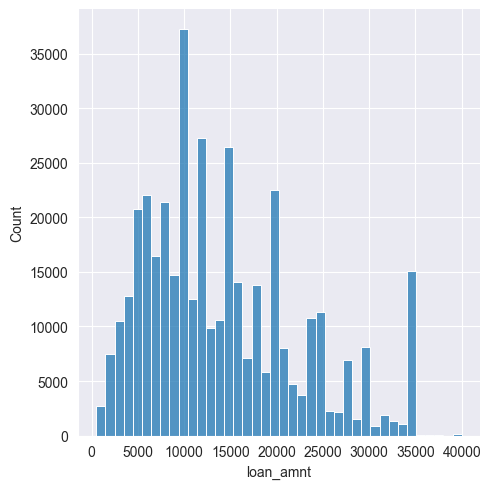

In [6]:
plt.figure(figsize=(12,4))
sns.displot(df['loan_amnt'],kde=False,bins=40)

In [7]:
df.corr().transpose()

/var/folders/g6/hdyghyt1739g71l3ff_mz_d00000gn/T/ipykernel_70806/2153022153.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr().transpose()


,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
loan_amnt,1.000000,0.168921,0.953929,0.336887,0.016636,0.198556,-0.077779,0.328320,0.099911,0.223886,0.222315,-0.106539
int_rate,0.168921,1.000000,0.162758,-0.056771,0.079038,0.011649,0.060986,-0.011280,0.293659,-0.036404,-0.082583,0.057450
installment,0.953929,0.162758,1.000000,0.330381,0.015786,0.188973,-0.067892,0.316455,0.123915,0.202430,0.193694,-0.098628
annual_inc,0.336887,-0.056771,0.330381,1.000000,-0.081685,0.136150,-0.013720,0.299773,0.027871,0.193023,0.236320,-0.050162
dti,0.016636,0.079038,0.015786,-0.081685,1.000000,0.136181,-0.017639,0.063571,0.088375,0.102128,-0.025439,-0.014558
open_acc,0.198556,0.011649,0.188973,0.136150,0.136181,1.000000,-0.018392,0.221192,-0.131420,0.680728,0.109205,-0.027732
pub_rec,-0.077779,0.060986,-0.067892,-0.013720,-0.017639,-0.018392,1.000000,-0.101664,-0.075910,0.019723,0.011552,0.699408
revol_bal,0.328320,-0.011280,0.316455,0.299773,0.063571,0.221192,-0.101664,1.000000,0.226346,0.191616,0.194925,-0.124532
revol_util,0.099911,0.293659,0.123915,0.027871,0.088375,-0.131420,-0.075910,0.226346,1.000000,-0.104273,0.007514,-0.086751
total_acc,0.223886,-0.036404,0.202430,0.193023,0.102128,0.680728,0.019723,0.191616,-0.104273,1.000000,0.381072,0.042035


/var/folders/g6/hdyghyt1739g71l3ff_mz_d00000gn/T/ipykernel_70806/1493450973.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True,cmap='plasma')


<AxesSubplot: >

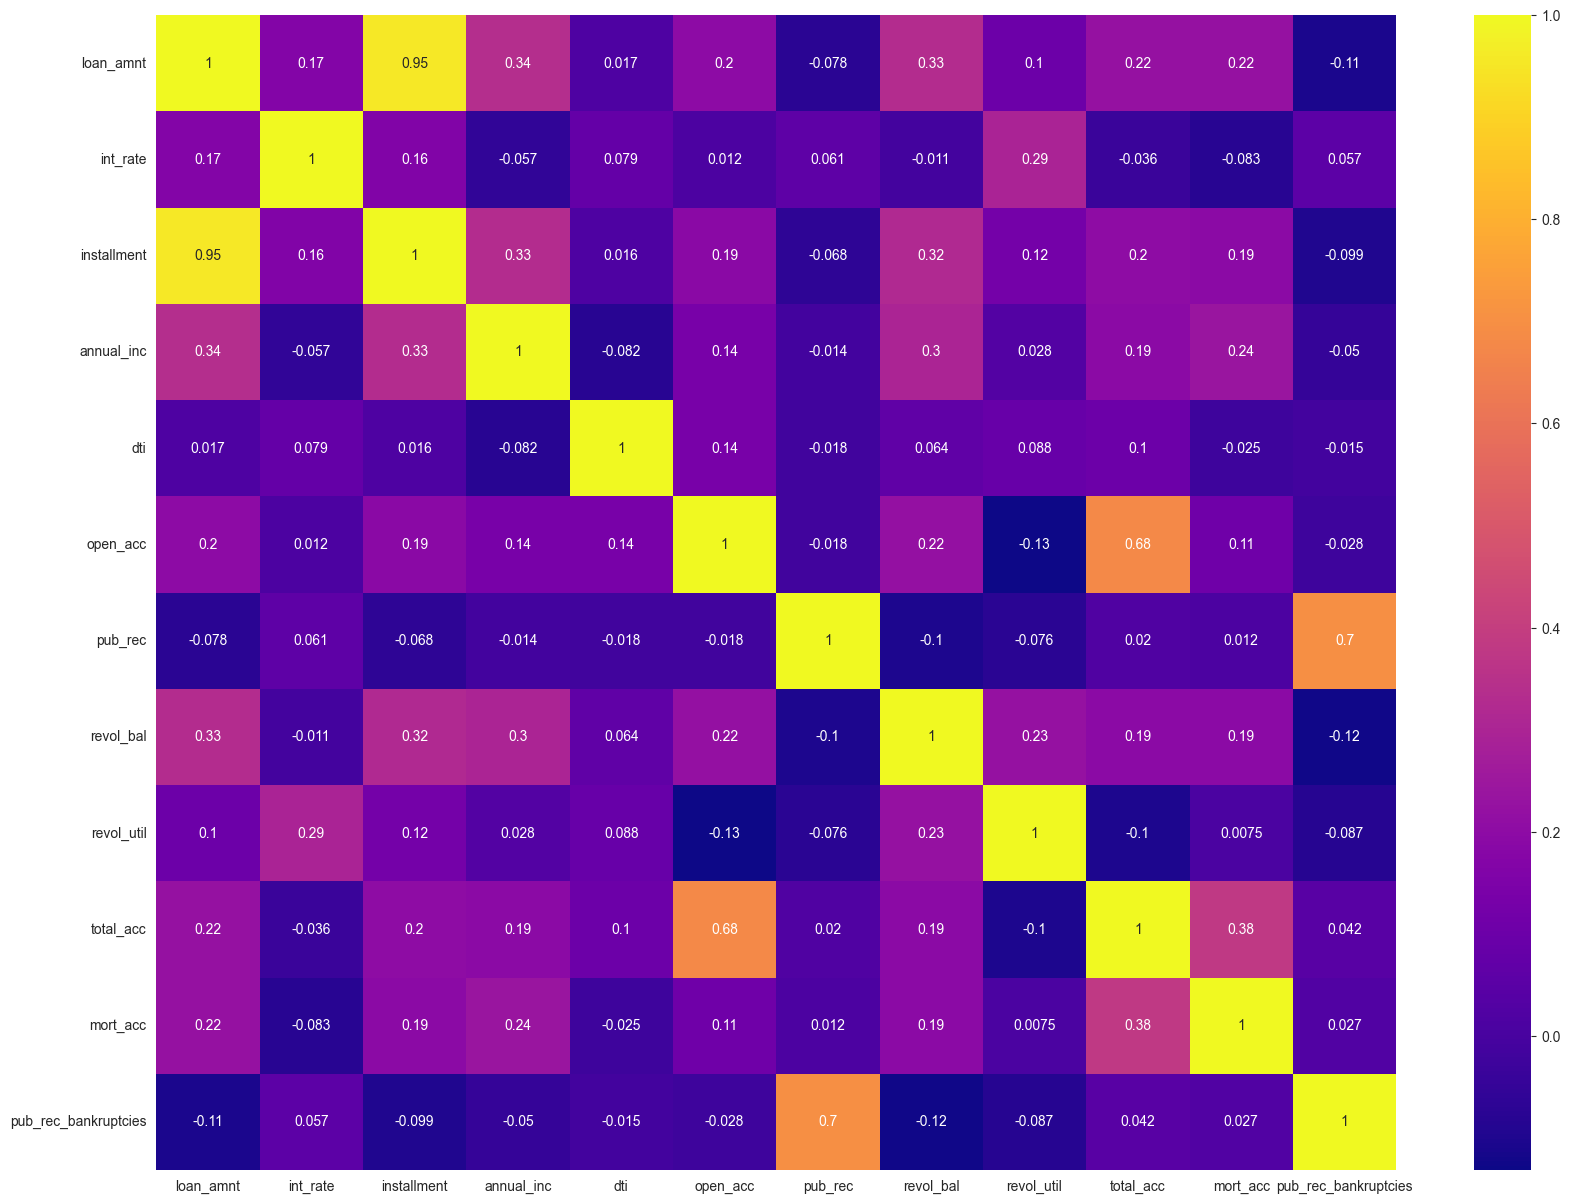

In [8]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(),annot=True,cmap='plasma')

In [9]:
# correlation close to 1 does not contribute to the model, as it acts similar as the target variable
feat_info('installment')
feat_info('loan_amnt')

The monthly payment owed by the borrower if the loan originates.
The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.


<AxesSubplot: xlabel='installment', ylabel='loan_amnt'>

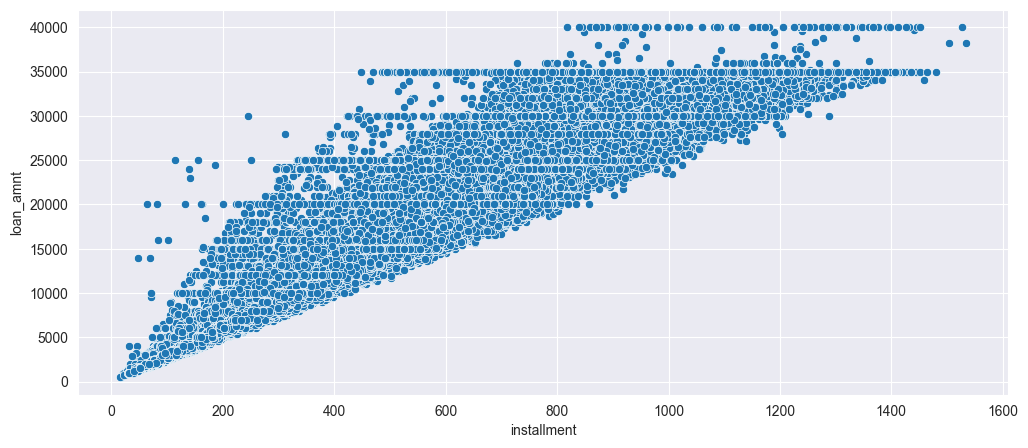

In [10]:
plt.figure(figsize=(12,5))
sns.scatterplot(x='installment',y='loan_amnt',data=df)

<AxesSubplot: xlabel='loan_status', ylabel='loan_amnt'>

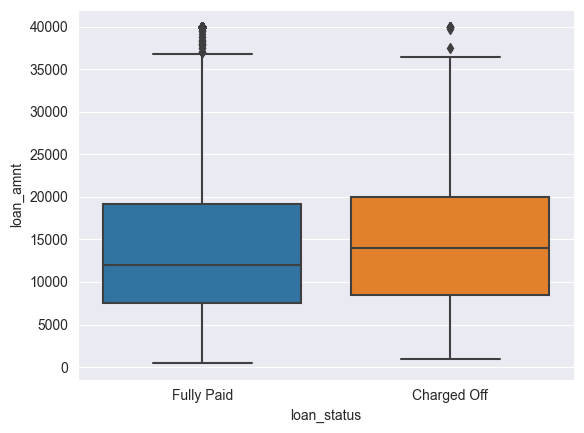

In [11]:
sns.boxplot(x='loan_status',y='loan_amnt',data=df)
# if the loan ammnt is higher theres a higher chance that it will be charged off

In [12]:
df.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15126.300967,8505.090557,1000.0,8525.0,14000.0,20000.0,40000.0
Fully Paid,318357.0,13866.878771,8302.319699,500.0,7500.0,12000.0,19225.0,40000.0


In [13]:
# unique possible grades and subgrades of customers
df['grade'].unique()

array(['B', 'A', 'C', 'E', 'D', 'F', 'G'], dtype=object)

In [14]:
df['sub_grade'].unique()

array(['B4', 'B5', 'B3', 'A2', 'C5', 'C3', 'A1', 'B2', 'C1', 'A5', 'E4',
       'A4', 'A3', 'D1', 'C2', 'B1', 'D3', 'D5', 'D2', 'E1', 'E2', 'E5',
       'F4', 'E3', 'D4', 'G1', 'F5', 'G2', 'C4', 'F1', 'F3', 'G5', 'G4',
       'F2', 'G3'], dtype=object)

<AxesSubplot: xlabel='grade', ylabel='count'>

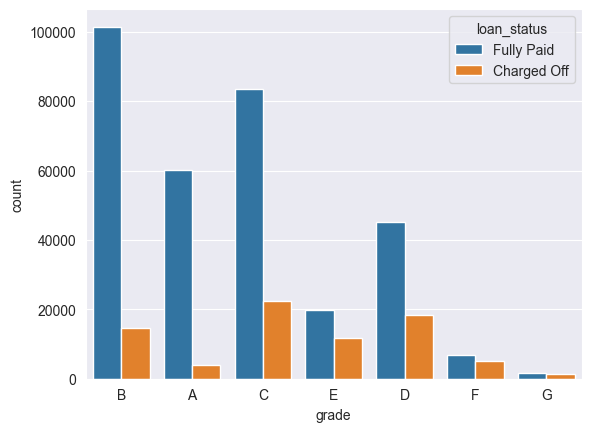

In [15]:
sns.countplot(x='grade',data=df,hue='loan_status')

<AxesSubplot: xlabel='sub_grade', ylabel='count'>

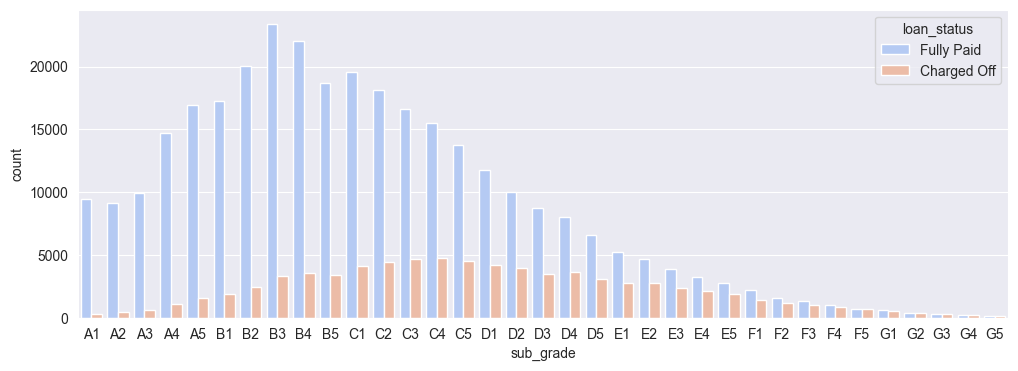

In [16]:
plt.figure(figsize=(12,4))
subgrade_order = sorted(df['sub_grade'].unique()) # sorted call of unique subgrades
sns.countplot(x='sub_grade',data=df,order=subgrade_order,palette='coolwarm',hue='loan_status')

<AxesSubplot: xlabel='sub_grade', ylabel='count'>

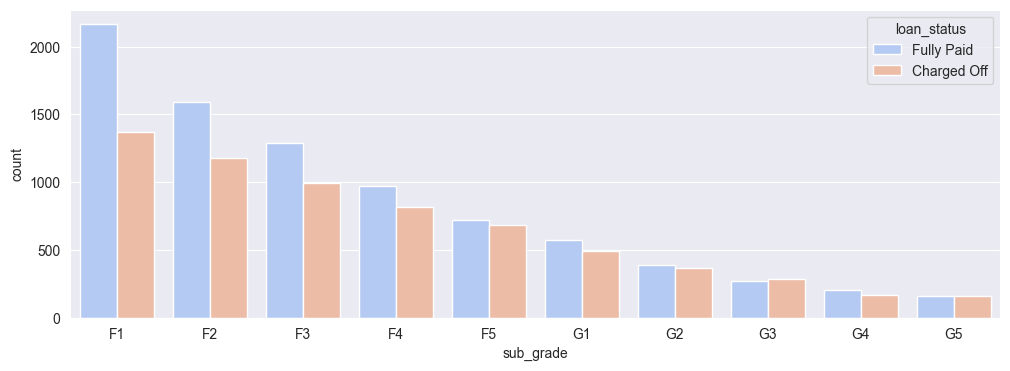

In [17]:
# F and G graded loans are not paid back often -- analyze these grades in greater detail
f_and_g = df[(df['grade']=='G') | (df['grade']=='F')]

plt.figure(figsize=(12,4))
subgrade_order = sorted(f_and_g['sub_grade'].unique()) # sorted call of unique subgrades
sns.countplot(x='sub_grade',data=f_and_g,order=subgrade_order,palette='coolwarm',hue='loan_status')

In [18]:
# creating a new column 'loan_repaid' where 0 == not repaid, 1 == fully repaid
df['loan_repaid'] = df['loan_status'].map({'Fully Paid':1,'Charged Off':0})

In [19]:
df[['loan_repaid','loan_status']]

,loan_repaid,loan_status
0,1,Fully Paid
1,1,Fully Paid
2,1,Fully Paid
3,1,Fully Paid
4,0,Charged Off
...,...,...
396025,1,Fully Paid
396026,1,Fully Paid
396027,1,Fully Paid
396028,1,Fully Paid


/var/folders/g6/hdyghyt1739g71l3ff_mz_d00000gn/T/ipykernel_70806/968076300.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['loan_repaid'].sort_values().drop('loan_repaid').plot(kind='bar')


<AxesSubplot: >

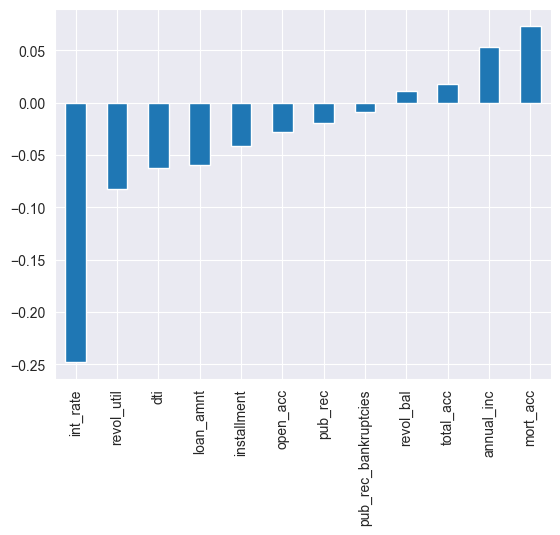

In [20]:
df.corr()['loan_repaid'].sort_values().drop('loan_repaid').plot(kind='bar')
# correlation of attributes with wether of not a loan is repaid

In [21]:
# data preprocessing and data cleaning

In [22]:
df.isnull().sum() # sum of missing values in each column

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_repaid                 0
dtype: int64

In [23]:
100 * df.isnull().sum() / len(df) # missing values in % 

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
loan_repaid             0.000000
dtype: float64

In [24]:
# employnment title and employnment lenght <= can we drop them?
# employnment title == job title
# employnment lenght == employnment lenght in years
df['emp_title'].value_counts()

Teacher                    4389
Manager                    4250
Registered Nurse           1856
RN                         1846
Supervisor                 1830
                           ... 
Postman                       1
McCarthy & Holthus, LLC       1
jp flooring                   1
Histology Technologist        1
Gracon Services, Inc          1
Name: emp_title, Length: 173105, dtype: int64

In [25]:
df = df.drop('emp_title',axis=1)
# too many individual/unique categoties, we cannot replace them with a categorical variable

In [26]:
sorted(df['emp_length'].dropna().unique())

['1 year',
 '10+ years',
 '2 years',
 '3 years',
 '4 years',
 '5 years',
 '6 years',
 '7 years',
 '8 years',
 '9 years',
 '< 1 year']

In [27]:
emp_length_order = ['< 1 year','1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']

<AxesSubplot: xlabel='emp_length', ylabel='count'>

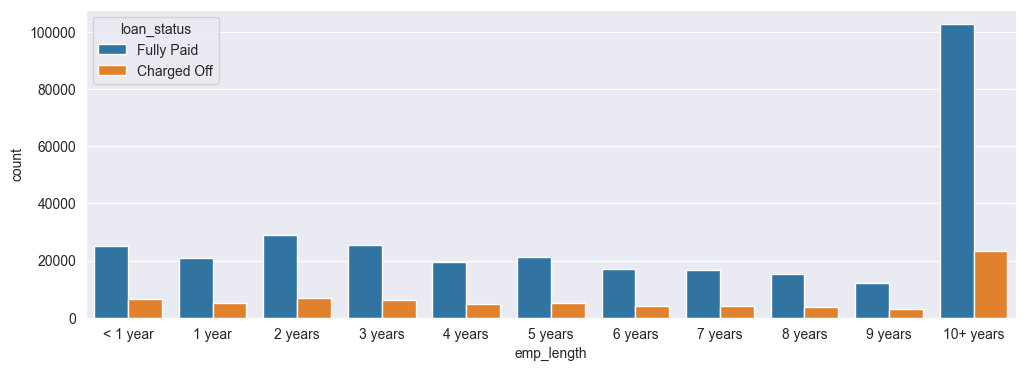

In [28]:
plt.figure(figsize=(12,4))
sns.countplot(x='emp_length',data=df,order=emp_length_order,hue='loan_status')
# if the blue-orange ratio is similar in all categories, then it is not an important variable for the NN

In [29]:
emp_co = df[df['loan_status']=='Charged Off'].groupby('emp_length').count()['loan_status']
emp_fp = df[df['loan_status']=='Fully Paid'].groupby('emp_length').count()['loan_status']

In [30]:
# % between charged off / fully paid as of emp_len
emp_co/(emp_fp+emp_co)

emp_length
1 year       0.199135
10+ years    0.184186
2 years      0.193262
3 years      0.195231
4 years      0.192385
5 years      0.192187
6 years      0.189194
7 years      0.194774
8 years      0.199760
9 years      0.200470
< 1 year     0.206872
Name: loan_status, dtype: float64

In [31]:
emp_len = emp_co/(emp_fp+emp_co)

<AxesSubplot: xlabel='emp_length'>

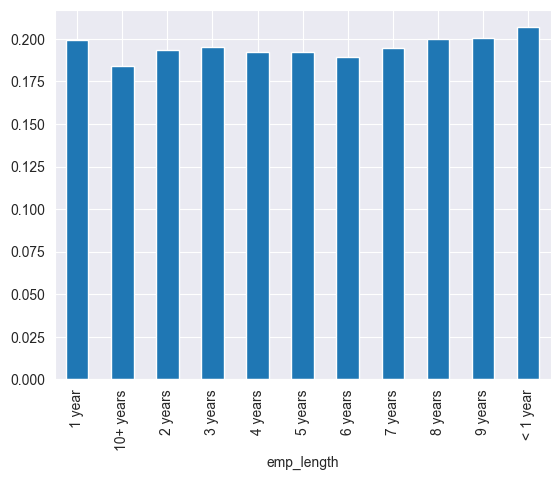

In [32]:
emp_len.plot(kind='bar') # the difference is not extreme enough to validate this feature => drop

In [33]:
df = df.drop('emp_length',axis=1)

In [34]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_repaid                 0
dtype: int64

In [35]:
df['title'].head() # subcategory desc. of the purpose

0                   Vacation
1         Debt consolidation
2    Credit card refinancing
3    Credit card refinancing
4      Credit Card Refinance
Name: title, dtype: object

In [36]:
df = df.drop('title',axis=1)

In [37]:
feat_info('mort_acc')

Number of mortgage accounts.


In [38]:
df['mort_acc'].value_counts()

0.0     139777
1.0      60416
2.0      49948
3.0      38049
4.0      27887
5.0      18194
6.0      11069
7.0       6052
8.0       3121
9.0       1656
10.0       865
11.0       479
12.0       264
13.0       146
14.0       107
15.0        61
16.0        37
17.0        22
18.0        18
19.0        15
20.0        13
24.0        10
22.0         7
21.0         4
25.0         4
27.0         3
32.0         2
31.0         2
23.0         2
26.0         2
28.0         1
30.0         1
34.0         1
Name: mort_acc, dtype: int64

In [39]:
# wich of other features correlates highly with mort_acc, so that we can use the information stored in that variable
df.corr()['mort_acc'].sort_values()

/var/folders/g6/hdyghyt1739g71l3ff_mz_d00000gn/T/ipykernel_70806/3756573884.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['mort_acc'].sort_values()


int_rate               -0.082583
dti                    -0.025439
revol_util              0.007514
pub_rec                 0.011552
pub_rec_bankruptcies    0.027239
loan_repaid             0.073111
open_acc                0.109205
installment             0.193694
revol_bal               0.194925
loan_amnt               0.222315
annual_inc              0.236320
total_acc               0.381072
mort_acc                1.000000
Name: mort_acc, dtype: float64

In [40]:
# total account has a reasonable positive correlation -- can use it to fill in missing values
# df.groupby('total_acc').mean() # averages of different categories in total account
df.groupby('total_acc').mean()['mort_acc'] # replace of mort acc values based on total account means

/var/folders/g6/hdyghyt1739g71l3ff_mz_d00000gn/T/ipykernel_70806/2381071143.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('total_acc').mean()['mort_acc'] # replace of mort acc values based on total account means


total_acc
2.0      0.000000
3.0      0.052023
4.0      0.066743
5.0      0.103289
6.0      0.151293
           ...   
124.0    1.000000
129.0    1.000000
135.0    3.000000
150.0    2.000000
151.0    0.000000
Name: mort_acc, Length: 118, dtype: float64

In [41]:
total_acc_avg = df.groupby('total_acc').mean()['mort_acc']

/var/folders/g6/hdyghyt1739g71l3ff_mz_d00000gn/T/ipykernel_70806/625993606.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_acc_avg = df.groupby('total_acc').mean()['mort_acc']


In [42]:
# filling out missing values in mort_acc
def fill_mort_acc(total_acc,mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc]
    else:
        return mort_acc

In [43]:
df['mort_acc'] = df.apply(lambda x: fill_mort_acc(x['total_acc'],x['mort_acc']),axis=1)

In [44]:
df.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
grade                     0
sub_grade                 0
home_ownership            0
annual_inc                0
verification_status       0
issue_d                   0
loan_status               0
purpose                   0
dti                       0
earliest_cr_line          0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util              276
total_acc                 0
initial_list_status       0
application_type          0
mort_acc                  0
pub_rec_bankruptcies    535
address                   0
loan_repaid               0
dtype: int64

In [45]:
df = df.dropna() # the rest is not significant, it is a very little part of the database

In [46]:
df.isnull().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
address                 0
loan_repaid             0
dtype: int64

Data cleaning: categorical data, string data

In [47]:
# listing the non-numeric columns
df.select_dtypes(['object']).columns

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'earliest_cr_line',
       'initial_list_status', 'application_type', 'address'],
      dtype='object')

In [48]:
feat_info('term')

The number of payments on the loan. Values are in months and can be either 36 or 60.


In [49]:
dummies = pd.get_dummies(df[['verification_status','application_type','initial_list_status','purpose']],drop_first=True)
df = pd.concat([df.drop(['verification_status','application_type','initial_list_status','purpose'],axis=1),dummies],axis=1)

In [50]:
df['home_ownership'].value_counts()
# None and any is very few -- we can put those in the other category
# value counts has been ran again, after the replace function...

MORTGAGE    198022
RENT        159395
OWN          37660
OTHER          110
NONE            29
ANY              3
Name: home_ownership, dtype: int64

In [51]:
# replace non and any with other
df['home_ownership'] = df['home_ownership'].replace(['NONE','ANY'],'OTHER')

In [52]:
dummies = pd.get_dummies(df['home_ownership'],drop_first=True)
df = pd.concat([df.drop(['home_ownership'],axis=1),dummies],axis=1)

In [53]:
df['address']

0              0174 Michelle Gateway\nMendozaberg, OK 22690
1           1076 Carney Fort Apt. 347\nLoganmouth, SD 05113
2           87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113
3                     823 Reid Ford\nDelacruzside, MA 00813
4                      679 Luna Roads\nGreggshire, VA 11650
                                ...                        
396025       12951 Williams Crossing\nJohnnyville, DC 30723
396026    0114 Fowler Field Suite 028\nRachelborough, LA...
396027     953 Matthew Points Suite 414\nReedfort, NY 70466
396028    7843 Blake Freeway Apt. 229\nNew Michael, FL 2...
396029          787 Michelle Causeway\nBriannaton, AR 48052
Name: address, Length: 395219, dtype: object

In [54]:
# extract the zipcode from the address attribute
df['address'].apply(lambda address:address[-5:])

0         22690
1         05113
2         05113
3         00813
4         11650
          ...  
396025    30723
396026    05113
396027    70466
396028    29597
396029    48052
Name: address, Length: 395219, dtype: object

In [55]:
df['zip_code'] = df['address'].apply(lambda address:address[-5:])

In [56]:
df['zip_code'].value_counts()

70466    56880
22690    56413
30723    56402
48052    55811
00813    45725
29597    45393
05113    45300
11650    11210
93700    11126
86630    10959
Name: zip_code, dtype: int64

In [57]:
dummies = pd.get_dummies(df['zip_code'],drop_first=True)
df = pd.concat([df.drop(['zip_code'],axis=1),dummies],axis=1)

In [58]:
df = df.drop('address',axis=1)

In [59]:
feat_info('issue_d')

The month which the loan was funded


In [60]:
# when we decide who to give a loan, we do not have a date about the fund
df = df.drop('issue_d',axis=1)

In [61]:
feat_info('earliest_cr_line')

The month the borrower's earliest reported credit line was opened


In [62]:
# converting it to a date feature, or grab is based off its position
df['earliest_cr_line']

0         Jun-1990
1         Jul-2004
2         Aug-2007
3         Sep-2006
4         Mar-1999
            ...   
396025    Nov-2004
396026    Feb-2006
396027    Mar-1997
396028    Nov-1990
396029    Sep-1998
Name: earliest_cr_line, Length: 395219, dtype: object

In [63]:
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda date: int(date[-4:]))

In [64]:
df['earliest_cr_line']

0         1990
1         2004
2         2007
3         2006
4         1999
          ... 
396025    2004
396026    2006
396027    1997
396028    1990
396029    1998
Name: earliest_cr_line, Length: 395219, dtype: int64

In [65]:
df = df.drop('grade',axis=1)

In [66]:
subgrade_dummies = pd.get_dummies(df['sub_grade'],drop_first=True)

In [67]:
df = pd.concat([df.drop('sub_grade',axis=1),subgrade_dummies],axis=1)

In [68]:
df.head(5)

,loan_amnt,term,int_rate,installment,annual_inc,loan_status,dti,earliest_cr_line,open_acc,pub_rec,...,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5
0,10000.0,36 months,11.44,329.48,117000.0,Fully Paid,26.24,1990,16.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,8000.0,36 months,11.99,265.68,65000.0,Fully Paid,22.05,2004,17.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,15600.0,36 months,10.49,506.97,43057.0,Fully Paid,12.79,2007,13.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,7200.0,36 months,6.49,220.65,54000.0,Fully Paid,2.60,2006,6.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,24375.0,60 months,17.27,609.33,55000.0,Charged Off,33.95,1999,13.0,0.0,...,0,0,0,0,0,0,0,0,0,0


**Data preprocessing**

In [70]:
from sklearn.model_selection import train_test_split

In [71]:
# this has already been dropped in a previous runtime
# df = df.drop('loan_status',axis=1) # dropping the loan status, as loan repaid already has that information

In [72]:
X = df.drop('loan_repaid',axis=1).values
y = df['loan_repaid'].values

In [73]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=101)

In [74]:
from sklearn.preprocessing import MinMaxScaler

In [75]:
scaler = MinMaxScaler()

In [76]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

ValueError: could not convert string to float: ' 36 months'

**Creating the NN model**